In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
from os.path import join
import json
import numpy as np
import pandas as pd
from rouge_score import rouge_scorer
from tqdm.auto import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from scipy.stats import sem
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties
import seaborn as sns
import copy
from natsort import natsorted
import os
from os.path import join 
from pathlib import Path
from scipy.stats import ks_2samp
from scipy.stats import hmean
font_path = '../Times New Roman.ttf'
prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()
# add font to font manager 
font_manager.fontManager.addfont(font_path)

%matplotlib inline
sns.set_theme(style="whitegrid", font_scale=1.5, font=prop.get_name())

colors = list(sns.color_palette("magma", n_colors=8))
fs=22


/data/user_data/zhilif/anaconda3/envs/tf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/user_data/zhilif/anaconda3/envs/tf/lib/python3.12/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
def get_mean_df(df):
    mean_df = copy.deepcopy(df)
    # delete row "generated_text"
    mean_df = mean_df.drop(['generated_text', 'normalized_gt_loss'], axis=0)
    mean_df.loc['avg_gt_prob']=np.zeros(len(mean_df.columns))
    # for each entry in df, the entry is a dict, get the mean of the values
    for eval_task, metrics in mean_df.items():
        # iterate through metrics
        for metric, res in metrics.items():
            # get mean
            # print(metric)
            if metric in ['avg_gt_prob', 'forget_quality', 'truth_ratio']:
                continue
            mean_df[eval_task][metric] = np.mean(list(res.values()))

        if 'eval_log' in eval_task:
            perplexities = np.array(list(df[eval_task]['avg_gt_loss'].values()))
            probs = np.exp(-1 * perplexities)
            mean_df[eval_task]['avg_gt_prob'] = np.mean(probs)

        else:
            avg_gt_loss = df[eval_task]['avg_gt_loss']
            avg_perturb_loss = df[eval_task]['average_perturb_loss']
            data_indices = avg_gt_loss.keys()
            normalized_gt_prob = {}
            for idx in data_indices:
                truth_prob = np.exp(-1 * avg_gt_loss[idx])
                perturb_prob = np.exp(-1 * np.array(avg_perturb_loss[idx]))
                all_prob = np.array([truth_prob, *perturb_prob])
                normalized_gt_prob[idx] = truth_prob / all_prob.sum()
            mean_df[eval_task]['avg_gt_prob'] = np.mean(np.array(list(normalized_gt_prob.values())))
        
        if eval_task == 'eval_log_forget.json':
            # truth_ratio = np.array(list(df[eval_task]['truth_ratio'].values()))
            # adjusted_truth_ratio = np.minimum(truth_ratio, 1/truth_ratio)

            avg_paraphrased_loss = df[eval_task]['avg_paraphrased_loss']
            avg_perturb_loss = df[eval_task]['average_perturb_loss']

            data_indices = list(avg_paraphrased_loss.keys())
            avg_paraphrased_loss = np.array([avg_paraphrased_loss[idx] for idx in data_indices])
            avg_perturb_loss = np.array([avg_perturb_loss[idx] for idx in data_indices]).mean(-1)

            truth_ratio = np.exp(avg_paraphrased_loss-avg_perturb_loss)
            adjusted_truth_ratio = np.minimum(truth_ratio, 1/truth_ratio)
            mean_df[eval_task]['truth_ratio'] = np.mean(adjusted_truth_ratio)
        else:
            avg_paraphrased_loss = df[eval_task]['avg_paraphrased_loss']
            avg_perturb_loss = df[eval_task]['average_perturb_loss']

            data_indices = list(avg_paraphrased_loss.keys())
            
            avg_paraphrased_loss = np.array([avg_paraphrased_loss[idx] for idx in data_indices])
            avg_perturb_loss = np.array([avg_perturb_loss[idx] for idx in data_indices]).mean(-1)
            truth_ratio = np.exp(avg_paraphrased_loss-avg_perturb_loss)
            
            adjusted_truth_ratio = np.maximum(0, 1-truth_ratio)
            mean_df[eval_task]['truth_ratio'] = np.mean(adjusted_truth_ratio)
            
    return mean_df

    

In [3]:
def get_forget_quality(unlearn_df, retain_df):
    unlearn_df.loc['forget_quality']=np.zeros(len(unlearn_df.columns))
    for eval_task, _ in unlearn_df.items():
        if eval_task == 'eval_log_forget.json':
            retain_truth_ratio = retain_df[eval_task]['truth_ratio']
            unlearn_truth_ratio = unlearn_df[eval_task]['truth_ratio']

            # data_indices = list(retain_truth_ratio.keys())
            # retain_truth_ratio = np.array([retain_truth_ratio[idx] for idx in data_indices])
            # unlearn_truth_ratio = np.array([unlearn_truth_ratio[idx] for idx in data_indices])
            # we have the assumption that the retain_df will always have a truth ratio length less than or equal to unlearn_df
            retain_truth_ratio = np.array(list(retain_truth_ratio.values()))
            unlearn_truth_ratio = np.array(list(unlearn_truth_ratio.values()))[-len(retain_truth_ratio):]

            ks_test = ks_2samp(retain_truth_ratio, unlearn_truth_ratio)
            pvalue = ks_test.pvalue
            unlearn_df[eval_task]['forget_quality'] = pvalue
    return unlearn_df
    


In [4]:
forget_rates=['forget01', 'forget05', 'forget10']
model_family = ['llama2-7b', 'phi']
wd = '0.01'
retain_model_path_dict = {
    'llama2-7b': {
        'forget01': f'/home/zhilif/tofu/paper_models/ft_epoch5_lr1e-05_llama2-7b_retain99_wd{wd}/checkpoint-618',
        'forget05': f'/home/zhilif/tofu/paper_models/ft_epoch5_lr1e-05_llama2-7b_retain95_wd{wd}/checkpoint-593',
        'forget10': f'/home/zhilif/tofu/paper_models/ft_epoch5_lr1e-05_llama2-7b_retain90_wd{wd}/checkpoint-562'
    },
    'phi': {
        'forget01': f'/home/zhilif/tofu/paper_models/ft_epoch5_lr2e-05_phi_retain99_wd{wd}/checkpoint-618',
        'forget05': f'/home/zhilif/tofu/paper_models/ft_epoch5_lr2e-05_phi_retain95_wd{wd}/checkpoint-593',
        'forget10': f'/home/zhilif/tofu/paper_models/ft_epoch5_lr2e-05_phi_retain90_wd{wd}/checkpoint-562'
    }
}
retain_df_dict = {}
mean_retain_df_dict = {}
for model in model_family:
    retain_df_dict[model] = {}
    mean_retain_df_dict[model] = {}
    for rate in forget_rates:
        retain_model_path = retain_model_path_dict[model][rate]
        retain_df_dict[model][rate] = pd.read_json(join(retain_model_path, f'eval_results/ds_size300/eval_log_aggregated.json'))
        mean_retain_df_dict[model][rate] = get_mean_df(retain_df_dict[model][rate])


In [5]:
model_family = ['llama2-7b', 'phi']
ft_model_path = {
    'llama2-7b': f'/home/zhilif/tofu/paper_models/ft_epoch5_lr1e-05_llama2-7b_full_wd{wd}/checkpoint-625',
    'phi': f'/home/zhilif/tofu/paper_models/ft_epoch5_lr2e-05_phi_full_wd{wd}/checkpoint-625'
}
algorithms = ['grad_ascent', 'grad_diff', 'idk', 'KL']
forget_rates=['forget01', 'forget05', 'forget10']
lr_map = {
    'phi': '2e-05',
    'llama2-7b': '1e-05',
}

df_dict = {}
for model in model_family:
    df_dict[model] = {}
    for algo in algorithms:
        df_dict[model][algo] = {}
        for rate in forget_rates:
            ft_df = pd.read_json(join(ft_model_path[model], f'eval_results/ds_size300/eval_log_aggregated.json'))
            retain_df = retain_df_dict[model][rate]
            ft_df = get_forget_quality(ft_df, retain_df)
            mean_ft_df = get_mean_df(ft_df)
            subfolder1 = join(ft_model_path[model], f'{algo}_1e-05_{rate}')
            # iterate through the subfolder of subfolder1 that starts with checkpoint
            ckpt_folders = os.listdir(subfolder1)
            ckpt_folders = natsorted([i for i in ckpt_folders if 'checkpoint' in i])
            ckpt_df = pd.DataFrame(index=mean_ft_df.index, columns=mean_ft_df.columns)

            ckpt_df_list = [mean_ft_df]
            for ckpt in ckpt_folders:
                eval_result_path = join(subfolder1, ckpt, 'eval_results/ds_size300/eval_log_aggregated.json')
                eval_result = pd.read_json(eval_result_path)
                eval_result = get_forget_quality(eval_result, retain_df)
                mean_df = get_mean_df(eval_result)
                ckpt_df_list.append(mean_df)
            
            for column in ckpt_df.columns:
                for index in ckpt_df.index:
                    # Concatenate the cell values across DataFrames into a list
                    ckpt_df.at[index, column] = [df.at[index, column] for df in ckpt_df_list]

            df_dict[model][algo][rate] = ckpt_df

In [6]:
def get_pareto_df(ckpt_df, retain_df):
    # ckpt_df has to be a dataframe where the cells are lists of checkpoint metrics, it should contain both fineuned and unlearned models
    model_utility_metrics = ['avg_gt_prob', 'rougeL_recall', 'truth_ratio']
    # create a new df to store the pareto front
    # make sure pareto_df uses double precision
    utility_metric_dict = {
        'avg_gt_prob': 'Prob.',
        'rougeL_recall': 'ROUGE',
        'truth_ratio': 'Truth Ratio'
    }
    forget_task = 'eval_log_forget.json'
    utility_task = ['eval_log.json', 'eval_real_author_wo_options.json', 'eval_real_world_wo_options.json']

    dataset_name_dict = {
        'eval_log.json': 'Retain',
        'eval_real_author_wo_options.json': 'Real Authors',
        'eval_real_world_wo_options.json': 'Real World',
        'eval_log_forget.json': 'Forget'
    }

    df_rows = ['Forget Quality', 'Model Utility']
    # take all combination between dataset_name and model_utility_metrics
    for dataset_name in dataset_name_dict.values():
        for metric in utility_metric_dict.values():
            df_rows.append(f'{metric} {dataset_name}')


    pareto_df = pd.DataFrame(
        index=df_rows, 
        columns=['Finetune Model', 'Retain Model', 'Unlearn Model']
    )


    ckpt_forget_quality = np.array(ckpt_df[forget_task]['forget_quality'], dtype=np.float64)
    ft_forget_quality = np.array(ckpt_forget_quality[0], dtype=np.float64)
    unlearn_forget_quality = np.array(ckpt_forget_quality[1:], dtype=np.float64)
    retain_forget_quality = 1 # this is by definition 
    # allow float 64 
    pareto_df.at['Forget Quality', 'Finetune Model'] = ft_forget_quality
    pareto_df.at['Forget Quality', 'Retain Model'] = retain_forget_quality
    pareto_df.at['Forget Quality', 'Unlearn Model'] = unlearn_forget_quality

    unlearn_utilities = []
    ft_utilities = []
    retain_utilities = []

    unlearn_forgets = []
    ft_forgets = []
    retain_forgets = []

    for task in utility_task:
        for metric in model_utility_metrics:
            ckpt_metric = ckpt_df[task][metric]
            ft_metric = ckpt_metric[0]
            unlearn_metric = ckpt_metric[1:]
            retain_metric = retain_df[task][metric]
            
            ft_utilities.append(ft_metric)
            unlearn_utilities.append(unlearn_metric)
            retain_utilities.append(retain_metric)

            pareto_df.at[f'{utility_metric_dict[metric]} {dataset_name_dict[task]}', 'Finetune Model'] = ft_metric
            pareto_df.at[f'{utility_metric_dict[metric]} {dataset_name_dict[task]}', 'Retain Model'] = retain_metric
            pareto_df.at[f'{utility_metric_dict[metric]} {dataset_name_dict[task]}', 'Unlearn Model'] = unlearn_metric
    
    for metric in model_utility_metrics:
        ckpt_metric = ckpt_df[forget_task][metric]
        ft_metric = ckpt_metric[0]
        unlearn_metric = ckpt_metric[1:]
        retain_metric = retain_df[forget_task][metric]

        pareto_df.at[f'{utility_metric_dict[metric]} {dataset_name_dict[forget_task]}', 'Finetune Model'] = ft_metric
        pareto_df.at[f'{utility_metric_dict[metric]} {dataset_name_dict[forget_task]}', 'Retain Model'] = retain_metric
        pareto_df.at[f'{utility_metric_dict[metric]} {dataset_name_dict[forget_task]}', 'Unlearn Model'] = unlearn_metric

    # get harmonic mean
    ft_utilities_hmean = hmean(np.array(ft_utilities, dtype=np.float64))
    unlearn_utilities_hmean = hmean(np.array(unlearn_utilities, dtype=np.float64), axis=0)
    retain_utilities_hmean = hmean(np.array(retain_utilities, dtype=np.float64))
    pareto_df.at['Model Utility', 'Finetune Model'] = ft_utilities_hmean
    pareto_df.at['Model Utility', 'Retain Model'] = retain_utilities_hmean
    pareto_df.at['Model Utility', 'Unlearn Model'] = unlearn_utilities_hmean

    return pareto_df

pareto_df_dict = {}
for model in model_family:
    pareto_df_dict[model] = {}
    for algo in algorithms:
        pareto_df_dict[model][algo] = {}
        for rate in forget_rates:
            pareto_df_dict[model][algo][rate] = get_pareto_df(df_dict[model][algo][rate], mean_retain_df_dict[model][rate])



In [7]:
curr_df = pareto_df_dict['phi']['grad_ascent']['forget05']
# get the row of 'Forget Quality' at column 'Unlearn Model'
curr_df.loc['Forget Quality']['Unlearn Model']


array([3.07995409e-12, 1.21275443e-10, 1.39210479e-06, 1.62584593e-02,
       1.12283603e-01])

# Drawing the Pareto plot of model utility vs forget quality


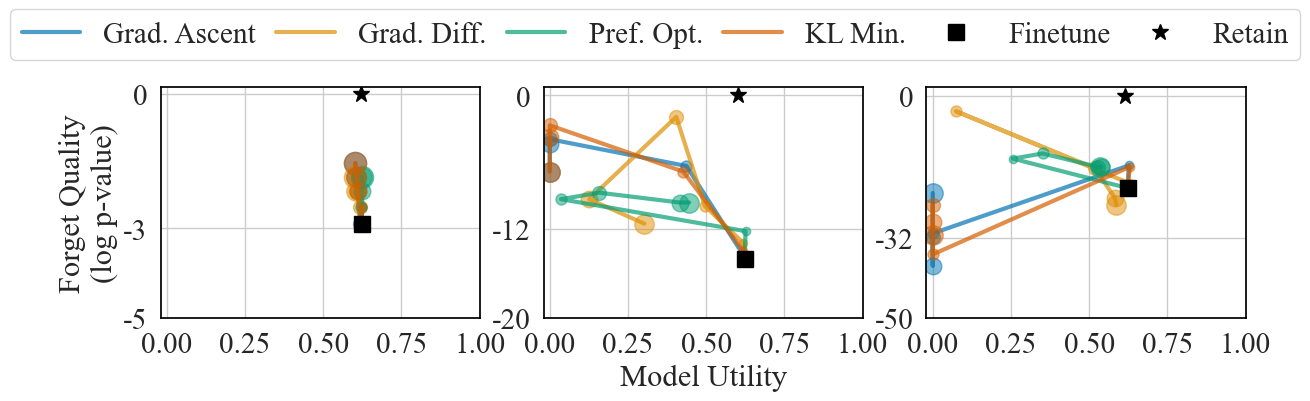

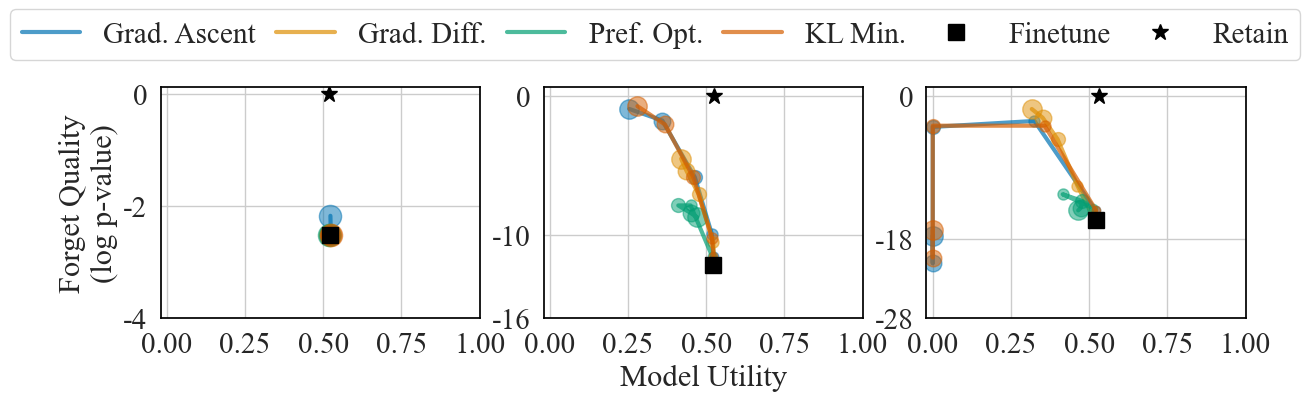

In [9]:
methods = ["grad_ascent", "grad_diff", "idk", "KL"]
label_name = {
    'grad_ascent': 'Grad. Ascent',
    'grad_diff': 'Grad. Diff.',
    'idk': 'Pref. Opt.',
    'KL': 'KL Min.'
}
# methods = ["idk"]

color_palette = sns.color_palette("colorblind", 4)
colors = {"grad_ascent": color_palette[0], "grad_diff": color_palette[1], "idk": color_palette[2], "KL": color_palette[3]}
sns.set_theme(style="whitegrid", font_scale=1.5, font="Times New Roman")

for model in model_family:
    fig, axs = plt.subplots(1, 3, figsize=(14, 3), sharey=False)
    for i, rate in enumerate(forget_rates):
        ax = axs[i]

        # ax.plot([0, 1], [0.05, 0.05], color="black", linestyle="--", linewidth=2, alpha=0.7)

        for method in methods:
            pareto_df = pareto_df_dict[model][method][rate]
                

            model_utility = [pareto_df['Finetune Model']['Model Utility']] + list(pareto_df['Unlearn Model']['Model Utility'])
            # print(model_utility)
            # print(type(pareto_df['Unlearn Model']['Model Utility']), pareto_df['Finetune Model']['Model Utility'])
            forget_quality = [pareto_df['Finetune Model']['Forget Quality']] + list(pareto_df["Unlearn Model"]["Forget Quality"])
            # Plot each point individually with increasing marker size
            for j in range(len(model_utility)):
                ax.plot(model_utility[j], forget_quality[j], color=colors[method], marker='o', markersize=j * 2 + 4, alpha=0.5)  # Increasing marker size

            ax.plot(model_utility, forget_quality, label=label_name[method], color=colors[method], linestyle="-", linewidth=3, alpha=0.7)

        pareto_df = pareto_df_dict[model]['KL'][rate]
        ax.plot(pareto_df['Finetune Model']['Model Utility'], pareto_df["Finetune Model"]["Forget Quality"], label="Finetune", color="black", marker="s", markersize=12, linestyle='None')
        ax.plot(pareto_df['Retain Model']['Model Utility'], pareto_df["Retain Model"]["Forget Quality"], label="Retain", color="black", marker="*", markersize=12, linestyle='None')

        ax.set_xlim(-0.02, 0.8)
        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs - 1)
        # ax.set_ylim(10e-19, 0.01)
        ax.set_yscale('log')

        yticks = ax.get_yticks()[::2]
        # print(yticks)
        if yticks[-2]>0:
            yticks = yticks[:-1]
        yticks[-1] = 1
        ax.set_yticks(yticks)
        ax.set_yticklabels([int(np.log10(x)) for x in ax.get_yticks()], fontsize=fs - 1)
        
        # ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 2)
        # turn on all spines with black lines
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
    axs[1].set_xlabel("Model Utility", fontsize=fs)
    axs[0].set_ylabel("Forget Quality\n(log p-value)", fontsize=fs)

    axs[1].legend(fontsize=fs-1, loc='upper center', bbox_to_anchor=(0.35, 1.4), ncol=6, columnspacing=0.7)

                
    fig_model_name = {
        'phi': 'Phi',
        'llama2-7b': 'Llama-2-7B'
    }
    fig.savefig(f'figure/scatterplots/{fig_model_name[model]}-wd{wd}.pdf', bbox_inches='tight', format='pdf')


# Drawing the scatter plot where the x-axis is the training step, and y-axis is model utility or forget quality


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


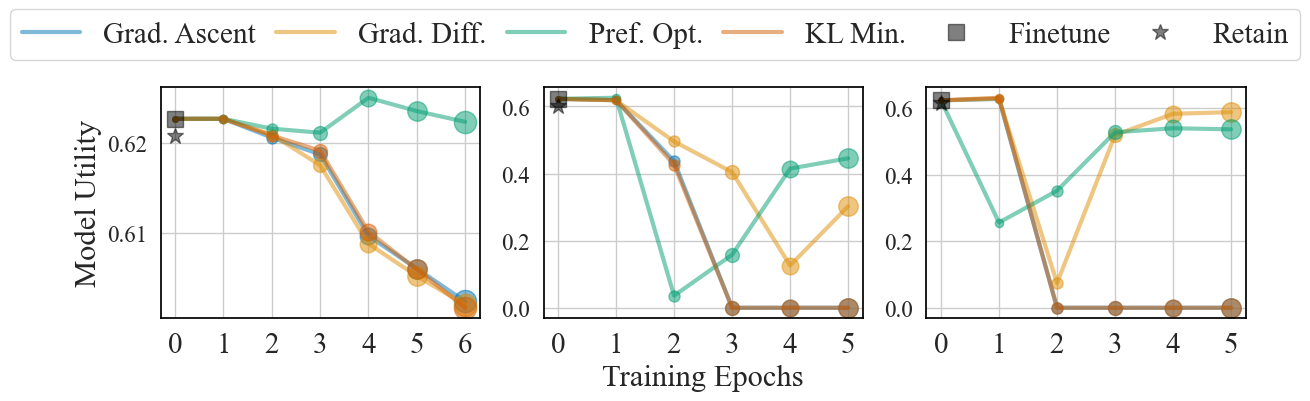

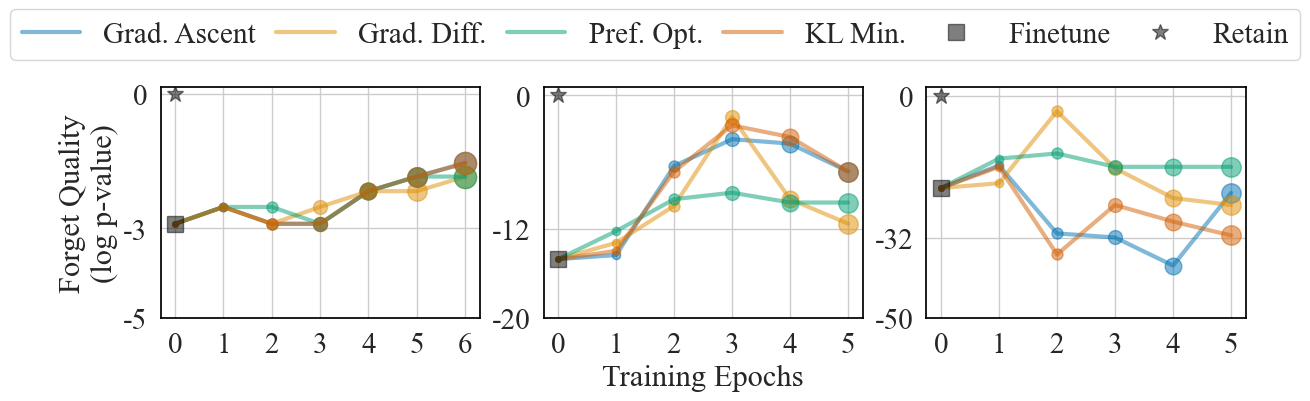

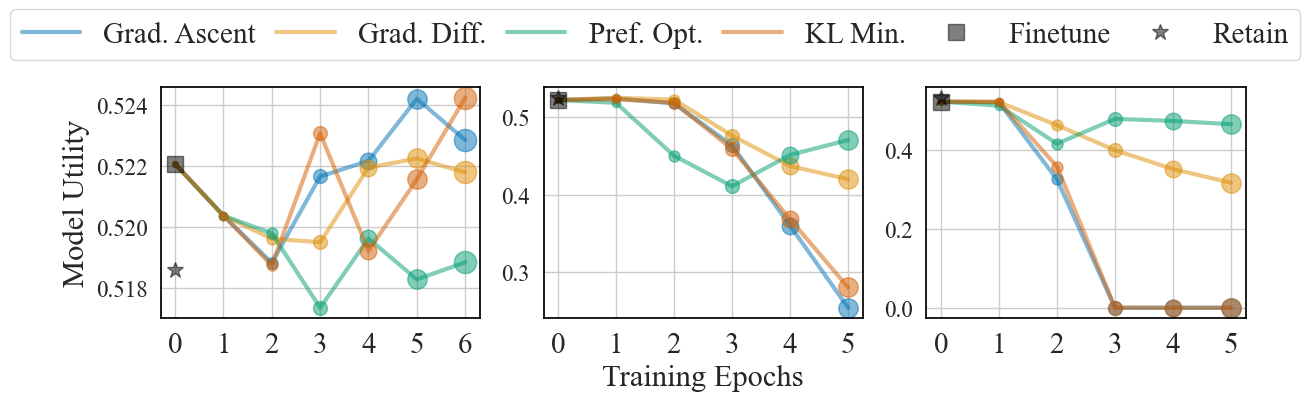

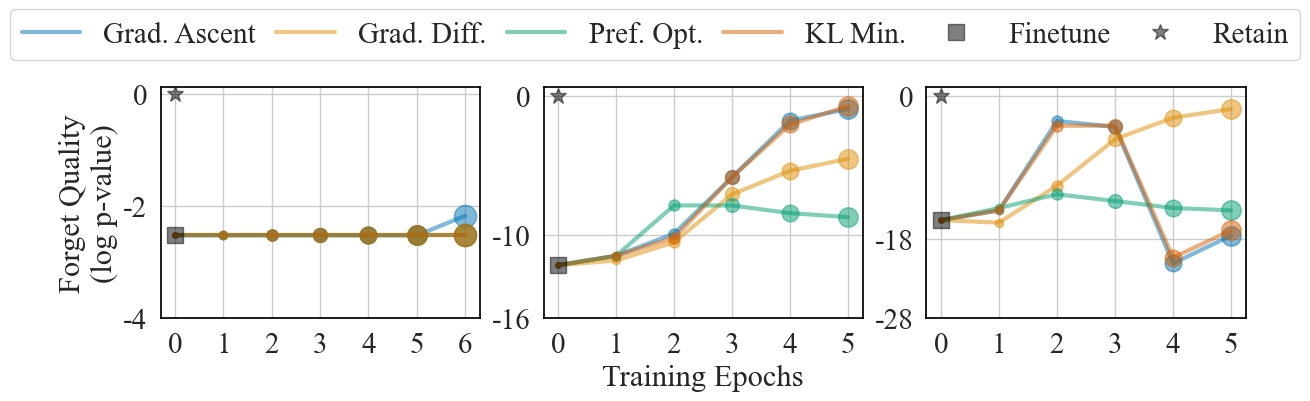

In [11]:
methods = ["grad_ascent", "grad_diff", "idk", "KL"]
label_name = {
    'grad_ascent': 'Grad. Ascent',
    'grad_diff': 'Grad. Diff.',
    'idk': 'Pref. Opt.',
    'KL': 'KL Min.'
}
# methods = ["idk"]

color_palette = sns.color_palette("colorblind", 4)
colors = {"grad_ascent": color_palette[0], "grad_diff": color_palette[1], "idk": color_palette[2], "KL": color_palette[3]}
sns.set_theme(style="whitegrid", font_scale=1.5, font="Times New Roman")
# forget_rates = ['forget01', 'forget05', 'forget10']
for model in model_family:
    # fig1 is for model_utility, and fig2 is for forget_quality
    fig1, axs1 = plt.subplots(1, 3, figsize=(14, 3), sharey=False)
    fig2, axs2 = plt.subplots(1, 3, figsize=(14, 3), sharey=False)
    for i, rate in enumerate(forget_rates):
        # ax = axs[i]
        # ax.plot([0, 1], [0.05, 0.05], color="black", linestyle="--", linewidth=2, alpha=0.7)

        for method in methods:
            pareto_df = pareto_df_dict[model][method][rate]

            model_utility = [pareto_df['Finetune Model']['Model Utility']] + list(pareto_df['Unlearn Model']['Model Utility'])
            # print(model_utility)
            # print(type(pareto_df['Unlearn Model']['Model Utility']), pareto_df['Finetune Model']['Model Utility'])
            forget_quality = [pareto_df['Finetune Model']['Forget Quality']] + list(pareto_df["Unlearn Model"]["Forget Quality"])
            # Plot each point individually with increasing marker size
            # axs1[i].plot(np.arange(len(model_utility)), model_utility, label=label_name[method], color=colors[method], marker='o', markersize=j * 2 + 4, alpha=0.5)
            # axs2[i].plot(np.arange(len(forget_quality)), forget_quality, label=label_name[method], color=colors[method], marker='o', markersize=j * 2 + 4, alpha=0.5)
            for j in range(len(model_utility)):
                axs1[i].plot(j, model_utility[j], color=colors[method], marker='o', markersize=j * 2 + 4, alpha=0.5)  # Increasing marker size
                axs2[i].plot(j, forget_quality[j], color=colors[method], marker='o', markersize=j * 2 + 4, alpha=0.5)  # Increasing marker size

            axs1[i].plot(np.arange(len(model_utility)), model_utility, label=label_name[method], color=colors[method], linestyle="-", linewidth=3, alpha=0.5)
            axs2[i].plot(np.arange(len(forget_quality)), forget_quality, label=label_name[method], color=colors[method], linestyle="-", linewidth=3, alpha=0.5)
        # pareto_df = pareto_df_dict[model]['KL'][rate]
        axs1[i].plot(0, pareto_df['Finetune Model']['Model Utility'], label="Finetune", color="black", marker="s", markersize=12, linestyle='None', alpha=0.5)
        axs1[i].plot(0, pareto_df['Retain Model']['Model Utility'], label="Retain", color="black", marker="*", markersize=12, linestyle='None', alpha=0.5)

        axs2[i].plot(0, pareto_df["Finetune Model"]["Forget Quality"], label="Finetune", color="black", marker="s", markersize=12, linestyle='None', alpha=0.5)
        axs2[i].plot(0, pareto_df["Retain Model"]["Forget Quality"], label="Retain", color="black", marker="*", markersize=12, linestyle='None', alpha=0.5)

        # draw a dashed line of 0.05 in axs2 
        # axs2[i].plot([0, 1], [0.05, 0.05], color="black", linestyle="--", linewidth=2, alpha=0.7)


        # axs1[i].plot(pareto_df['Finetune Model']['Model Utility'], pareto_df["Finetune Model"]["Forget Quality"], label="Finetune", color="black", marker="s", markersize=12, linestyle='None')
        # axs2[i].plot(pareto_df['Retain Model']['Model Utility'], pareto_df["Retain Model"]["Forget Quality"], label="Retain", color="black", marker="*", markersize=12, linestyle='None')
        for j, ax in enumerate([axs1[i], axs2[i]]):
            # ax.set_xlim(-0.02, 0.8)
            ax.set_xticks(np.arange(len(model_utility)))
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs - 1)
            # ax.set_ylim(10e-19, 0.01)
            if j == 1:
                ax.set_yscale('log')
                yticks = ax.get_yticks()[::2]
                # print(yticks)
                if yticks[-2]>0:
                    yticks = yticks[:-1]
                yticks[-1] = 1
                ax.set_yticks(yticks)
                ax.set_yticklabels([int(np.log10(x)) for x in ax.get_yticks()], fontsize=fs - 1)
            
            # ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 2)
            # turn on all spines with black lines
            ax.spines['bottom'].set_color('black')
            ax.spines['left'].set_color('black')
            ax.spines['top'].set_color('black')
            ax.spines['right'].set_color('black')

        axs1[1].set_xlabel("Training Epochs", fontsize=fs)
        axs1[0].set_ylabel("Model Utility", fontsize=fs)

        axs2[1].set_xlabel("Training Epochs", fontsize=fs)
        axs2[0].set_ylabel("Forget Quality\n(log p-value)", fontsize=fs)

        axs1[1].legend(fontsize=fs-1, loc='upper center', bbox_to_anchor=(0.35, 1.4), ncol=6, columnspacing=0.7)
        axs2[1].legend(fontsize=fs-1, loc='upper center', bbox_to_anchor=(0.35, 1.4), ncol=6, columnspacing=0.7)


    fig_model_name = {
        'phi': 'Phi',
        'llama2-7b': 'Llama-2-7B'
    }
    fig1.savefig(f'figure/scatterplots/{fig_model_name[model]}-wd{wd}-util_ckpt.pdf', bbox_inches='tight', format='pdf')
    fig2.savefig(f'figure/scatterplots/{fig_model_name[model]}-wd{wd}-forg_ckpt.pdf', bbox_inches='tight', format='pdf')


# Drawing zoomed in plot for forget01

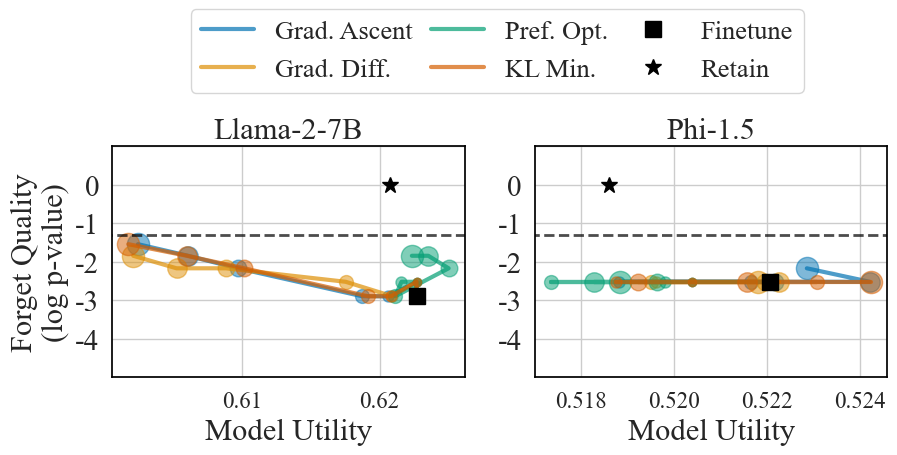

In [8]:
rate = 'forget01'
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=False)
for i, model in enumerate(model_family):
    ax = axs[i]
    pareto_df = pareto_df_dict[model]['KL'][rate]
    # ax.plot([0, 1], [0.05, 0.05], color="black", linestyle="--", linewidth=2, alpha=0.7)

    for method in methods:
        pareto_df = pareto_df_dict[model][method][rate]
            
        model_utility = [pareto_df['Finetune Model']['Model Utility']] + list(pareto_df['Unlearn Model']['Model Utility'])
        forget_quality = [pareto_df['Finetune Model']['Forget Quality']] + list(pareto_df["Unlearn Model"]["Forget Quality"])
        # Plot each point individually with increasing marker size
        for j in range(len(model_utility)):
            ax.plot(model_utility[j], forget_quality[j], color=colors[method], marker='o', markersize=j * 2 + 4, alpha=0.5)  # Increasing marker size

        ax.plot(model_utility, forget_quality, label=label_name[method], color=colors[method], linestyle="-", linewidth=3, alpha=0.7)
    ax.plot(pareto_df['Finetune Model']['Model Utility'], pareto_df["Finetune Model"]["Forget Quality"], label="Finetune", color="black", marker="s", markersize=12, linestyle='None')
    ax.plot(pareto_df['Retain Model']['Model Utility'], pareto_df["Retain Model"]["Forget Quality"], label="Retain", color="black", marker="*", markersize=12, linestyle='None')
 
    xmin, xmax = ax.get_xlim()
    ax.hlines(0.05, 0, 1, color="black", linestyle="--", linewidth=2, alpha=0.7)
    ax.set_xlim(xmin, xmax)
    # ax.set_xlim(-0.02, 0.8)
    # ax.set_xticks(np.arange(0, 1.1, 0.25))
    # ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs - 1)
    ax.set_yscale('log')
    # turn on all spines with black lines
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.set_xlabel("Model Utility", fontsize=fs)
    ax.set_title(["Llama-2-7B", "Phi-1.5"][i], fontsize=fs)
    ax.set_ylim(1e-4, 0.5)
    yticks = ax.get_yticks()
    ax.set_yticks(yticks)
    ax.set_yticklabels([""]+[int(np.log10(x)) for x in ax.get_yticks()[1:-1]]+[""], fontsize=fs - 1)
axs[0].set_ylabel("Forget Quality\n(log p-value)", fontsize=fs)
axs[1].legend(fontsize=fs-3, loc='upper right', bbox_to_anchor=(0.8, 1.65), ncol=3, columnspacing=0.7)


fig.savefig(f'figure/scatterplots/wd{wd}-forget01-zoom.pdf', bbox_inches='tight', format='pdf')


# Create Leaderboard CSV

In [9]:
def get_leaderboard_csv(pareto_df, algo):
    # get all table of the form "Unlearn Model Epoch x"
    expanded_df = copy.deepcopy(pareto_df)
    num_ckpts = len(expanded_df['Unlearn Model']['Forget Quality'])
    epoch_list = [f'{algo} Epoch {i+1}' for i in range(num_ckpts)]
    unlearn_df = pd.DataFrame(pareto_df['Unlearn Model'].tolist(), index=pareto_df.index).T
    # rename index to 'Unlearn Model Epoch x'
    unlearn_df.index = epoch_list

    finetune_df = pd.DataFrame(pareto_df['Finetune Model'].tolist(), index=pareto_df.index).T
    # rename index to 'Finetune Model'
    finetune_df.index = ['Finetune Model']
    retain_df = pd.DataFrame(pareto_df['Retain Model'].tolist(), index=pareto_df.index).T
    retain_df.index = ['Retain Model']
    return unlearn_df, finetune_df, retain_df

record_df = {}
leaderboard_df = {}
for model in model_family:
    record_df[model] = {}
    leaderboard_df[model] = {}
    for rate in forget_rates:
        record_df[model][rate] = {}
        leaderboard_df[model][rate] = {}
        for algo in algorithms:
            record_df[model][rate][algo] = get_leaderboard_csv(pareto_df_dict[model][algo][rate], label_name[algo])
        
        unlearn_dfs = [record_df[model][rate][algo][0] for algo in algorithms]
        finetune_df = record_df[model][rate][algorithms[-1]][1]
        retain_df = record_df[model][rate][algorithms[-1]][2]
        # merge unlearn_dfs, finetune_df, retain_df in one big df, with index name as the algorithm name
        merged_df = pd.concat([*unlearn_dfs, finetune_df, retain_df], axis=0)
        leaderboard_df[model][rate] = merged_df

In [20]:
leaderboard_df['phi']['forget01']['Forget Quality']

Grad. Ascent Epoch 1    0.003018
Grad. Ascent Epoch 2    0.003018
Grad. Ascent Epoch 3    0.003018
Grad. Ascent Epoch 4    0.003018
Grad. Ascent Epoch 5    0.003018
Grad. Ascent Epoch 6    0.006761
Grad. Diff. Epoch 1     0.003018
Grad. Diff. Epoch 2     0.003018
Grad. Diff. Epoch 3     0.003018
Grad. Diff. Epoch 4     0.003018
Grad. Diff. Epoch 5     0.003018
Grad. Diff. Epoch 6     0.003018
Pref. Opt. Epoch 1      0.003018
Pref. Opt. Epoch 2      0.003018
Pref. Opt. Epoch 3      0.003018
Pref. Opt. Epoch 4      0.003018
Pref. Opt. Epoch 5      0.003018
Pref. Opt. Epoch 6      0.003018
KL Min. Epoch 1         0.003018
KL Min. Epoch 2         0.003018
KL Min. Epoch 3         0.003018
KL Min. Epoch 4         0.003018
KL Min. Epoch 5         0.003018
KL Min. Epoch 6         0.003018
Finetune Model          0.003018
Retain Model            1.000000
Name: Forget Quality, dtype: float64